**Code Reference:** [Tf-Idf, Word2Vec, Embedding, Keras & SVC](https://www.kaggle.com/michaelhochstrasser/tf-idf-word2vec-embedding-keras-svc)

**Dataset Reference:** [Daily News for Stock Market Prediction](https://www.kaggle.com/aaron7sun/stocknews)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow

In [3]:
# import libraries yang dibutuhkan

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn.svm import SVC, LinearSVC
# from sklearn.linear_model import LogisticRegression
# from sklearn import tree
# from sklearn.mixture import GaussianMixture
# from sklearn.decomposition import PCA

from keras.models import Sequential

# Input Data dan Eksplorasi Data

Memuat data, Memeriksa dan menyiapkan Dataset.

File terdiri dari 25 judul berita Teratas per hari dan label dengan hanya dua nilai:

    "1" ketika nilai DJIA Adj Close naik atau tetap sama
    "0" ketika nilai DJIA Adj Close menurun

In [4]:
# import data
data = pd.read_csv('/content/drive/MyDrive/Tesis Oke/Combined_News_DJIA.csv')

# menampilkan isi data
data.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',"b'Gorbachev: ""Georgian military attacked the S...",b'CNN use footage of Tskhinvali ruins to cover...,b'Beginning a war as the Olympics were opening...,b'55 pyramids as large as the Luxor stacked in...,b'The 11 Top Party Cities in the World',b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who k

In [5]:
# mengecek dimensi data
data.shape

(1989, 27)

In [6]:
# mengecek type data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1989 entries, 0 to 1988
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    1989 non-null   object
 1   Label   1989 non-null   int64 
 2   Top1    1989 non-null   object
 3   Top2    1989 non-null   object
 4   Top3    1989 non-null   object
 5   Top4    1989 non-null   object
 6   Top5    1989 non-null   object
 7   Top6    1989 non-null   object
 8   Top7    1989 non-null   object
 9   Top8    1989 non-null   object
 10  Top9    1989 non-null   object
 11  Top10   1989 non-null   object
 12  Top11   1989 non-null   object
 13  Top12   1989 non-null   object
 14  Top13   1989 non-null   object
 15  Top14   1989 non-null   object
 16  Top15   1989 non-null   object
 17  Top16   1989 non-null   object
 18  Top17   1989 non-null   object
 19  Top18   1989 non-null   object
 20  Top19   1989 non-null   object
 21  Top20   1989 non-null   object
 22  Top21   1989 non-null   

In [7]:
# mengecek data yang kosong
data.isnull().sum()

Date     0
Label    0
Top1     0
Top2     0
Top3     0
Top4     0
Top5     0
Top6     0
Top7     0
Top8     0
Top9     0
Top10    0
Top11    0
Top12    0
Top13    0
Top14    0
Top15    0
Top16    0
Top17    0
Top18    0
Top19    0
Top20    0
Top21    0
Top22    0
Top23    1
Top24    3
Top25    3
dtype: int64

In [8]:
# distiribusi label target
data.groupby('Label').size()

Label
0     924
1    1065
dtype: int64

# Preprocessing

Pertama, semua headline digabung menjadi satu kolom yaitu menjadi kolom headlines

In [9]:
data['headlines'] = data[data.columns[2:]].apply(lambda x: '. '.join(x.dropna().astype(str)),axis=1)

In [10]:
data['headlines'].head(10)

0    b"Georgia 'downs two Russian warplanes' as cou...
1    b'Why wont America and Nato help us? If they w...
2    b'Remember that adorable 9-year-old who sang a...
3    b' U.S. refuses Israel weapons to attack Iran:...
4    b'All the experts admit that we should legalis...
5    b"Mom of missing gay man: Too bad he's not a 2...
6    b'In an Afghan prison, the majority of female ...
7    b"Man arrested and locked up for five hours af...
8    b'Two elderly Chinese women have been sentence...
9    b"British resident held in Guantanamo Bay wins...
Name: headlines, dtype: object

In [11]:
data.shape

(1989, 28)

Histogram dari panjang teks berita utama

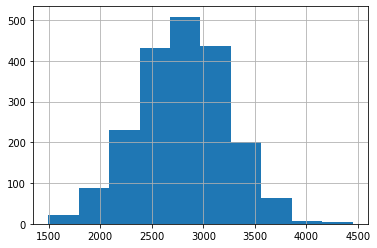

In [12]:
data['comment_length'] = data['headlines'].apply(lambda x : len(x))
data['comment_length'].hist()

In [13]:
data.isnull().sum()

Date              0
Label             0
Top1              0
Top2              0
Top3              0
Top4              0
Top5              0
Top6              0
Top7              0
Top8              0
Top9              0
Top10             0
Top11             0
Top12             0
Top13             0
Top14             0
Top15             0
Top16             0
Top17             0
Top18             0
Top19             0
Top20             0
Top21             0
Top22             0
Top23             1
Top24             3
Top25             3
headlines         0
comment_length    0
dtype: int64



Distribution of labels


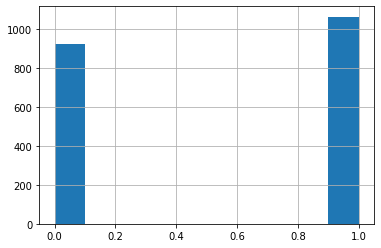

In [14]:
data['Label'].hist()

Membagi data menjadi rangkaian train dan test. Seperti yang diusulkan, data hingga 31.12.2014 digunakan sebagai set train dan dua tahun berikutnya sebagai set test. Ini kira-kira pembagian 80%/20%.

In [15]:
train = data[data['Date'] < '2015-01-01']
test = data[data['Date'] > '2014-12-31']

In [16]:
train.shape

(1611, 29)

In [17]:
test.shape

(378, 29)

# TF-IDF dan Classifier

## TF-IDF

Upaya pertama dengan Tf-idf dan Classifier sederhana

Mulai dari berita utama harian, kalimat-kalimat tersebut diubah menjadi kata-kata dengan menggunakan RegexpTokenizer dari nltk. Lemmatisasi juga diterapkan. CustomTokenizer berikut mengambil alih tugas ini.

In [18]:
import nltk
nltk.download('wordnet')

nltk.download('stopwords', quiet=True, raise_on_error=True)
stop_words_en = set(nltk.corpus.stopwords.words('english'))
stop_words_en.add("b")

class CustomTokenizer:
    
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        self.tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
        
    def _lem(self, token):
        if (token in stop_words_en):
            return token  # Memecahkan kesalahan "UserWarning: stop_words Anda mungkin tidak konsisten dengan prapemrosesan Anda."
        return self.wnl.lemmatize(token)
    
    def __call__(self, doc):
        return [self._lem(t) for t in self.tokenizer.tokenize(doc)]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Menggunakan CustomTokenizer, TfidfVectorizer mengonversi kumpulan headline mentah menjadi matriks fitur TF-IDF.

    Stopwords bahasa Inggris dihapus, semua kata diubah menjadi huruf kecil
    Dengan ngram_range=(2,2) hanya kata-tupel yang dipertimbangkan
    min_df dan max_df mengabaikan istilah yang memiliki frekuensi dokumen lebih rendah/lebih tinggi dari ambang batas yang diberikan (dalam persen)

Untuk pemasangan vectorizer, hanya training set yang digunakan.

In [19]:
vectorizer = CountVectorizer(tokenizer=CustomTokenizer(), stop_words=stop_words_en, lowercase=True, min_df=0.0075,  max_df=0.05, ngram_range=(2,2))

features_train = vectorizer.fit_transform(train['headlines'].tolist())
features_test = vectorizer.transform(test['headlines'].tolist())

In [20]:
features_train.shape

(1611, 1219)

In [21]:
features_test.shape

(378, 1219)

Periksa nama fitur dan fitur TF-IDF

In [22]:
feature_names = vectorizer.get_feature_names()
print(feature_names[50:100])

X_train = pd.DataFrame(features_train.todense(), columns = feature_names)
X_test = pd.DataFrame(features_test.todense(), columns = feature_names)

X_train.head()

['250 000', '3 000', '3 billion', '3 day', '3 million', '3 year', '30 000', '30 million', '30 year', '300 000', '300 million', '4 000', '4 5', '4 billion', '4 day', '4 million', '4 year', '40 000', '40 year', '48 hour', '5 000', '5 billion', '5 million', '5 year', '50 000', '50 million', '50 year', '500 000', '500 year', '6 000', '6 billion', '6 million', '6 month', '60 000', '60 year', '7 billion', '7 year', '70 000', '70 percent', '8 000', '8 year', '9 11', '9 year', 'abc news', 'abuse scandal', 'according new', 'according report', 'accuses u', 'acid attack', 'across country']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,000 000,000 dead,000 euro,000 troop,000 year,1 2,1 3,1 4,1 5,1 500,1 6,1 billion,1 million,10 000,10 day,10 million,10 year,100 000,100 million,100 year,11 year,12 000,12 year,13 year,14 year,15 000,15 year,150 000,16 000,16 year,17 year,18 year,19 year,2 000,2 3,2 5,2 billion,2 day,2 million,2 year,...,wind farm,wind power,without border,without charge,woman arrested,woman child,woman girl,woman raped,woman right,woman sentenced,world bank,world biggest,world cup,world economy,world first,world health,world heritage,world largest,world leader,world news,world oldest,world population,world richest,would allow,would like,would make,x post,xpost r,year jail,year later,year since,year u,year world,york time,young child,young girl,young men,young people,young woman,yr old
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [23]:
from collections import defaultdict

up_unigrams = defaultdict(int)
down_unigrams = defaultdict(int)

for word in feature_names:
    up_unigrams[word] += np.sum(X_train[train['Label']==1][word])
    down_unigrams[word] += np.sum(X_train[train['Label']==0][word])
        
df_up_unigrams = pd.DataFrame(sorted(up_unigrams.items(), key=lambda x: x[1])[::-1])
df_down_unigrams = pd.DataFrame(sorted(down_unigrams.items(), key=lambda x: x[1])[::-1])
df_up_unigrams.head()

,0,1
0,islamic state,73
1,world cup,60
2,bin laden,51
3,supreme court,50
4,right group,50


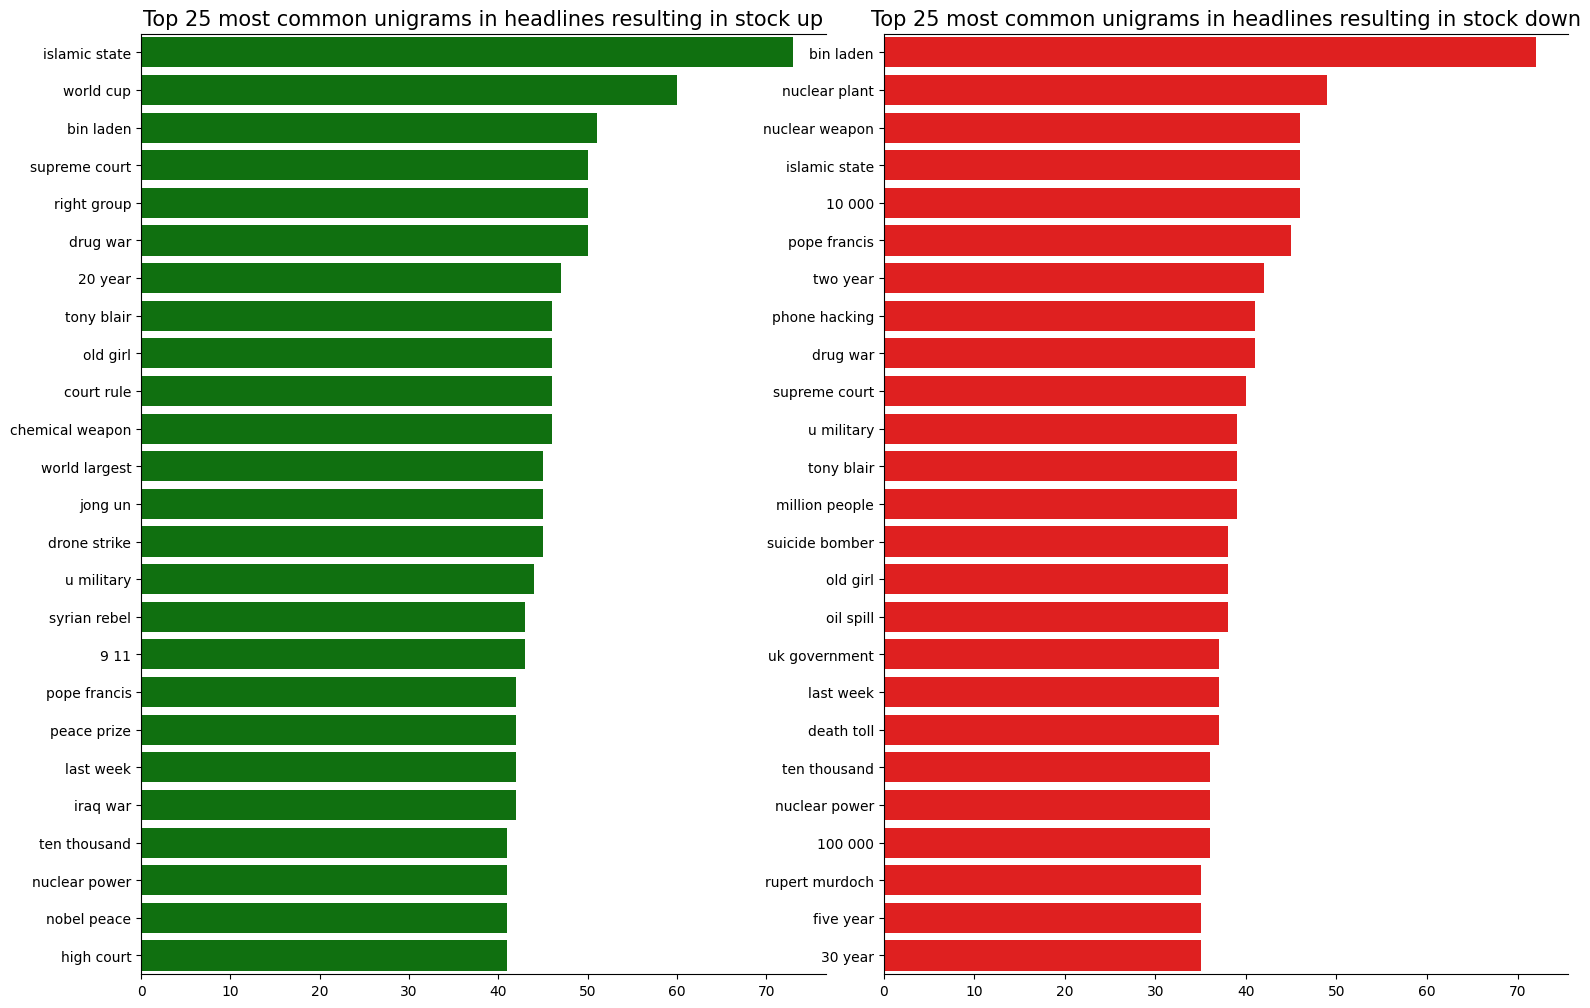

In [24]:
import seaborn as sns

N=25

fig, axes = plt.subplots(ncols=2, figsize=(15, 10), dpi=100)
plt.tight_layout()

sns.barplot(y=df_up_unigrams[0].values[:N], x=df_up_unigrams[1].values[:N], ax=axes[0], color='green')
sns.barplot(y=df_down_unigrams[0].values[:N], x=df_down_unigrams[1].values[:N], ax=axes[1], color='red')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=10)
    axes[i].tick_params(axis='y', labelsize=10)

axes[0].set_title(f'Top {N} most common unigrams in headlines resulting in stock up', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in headlines resulting in stock down', fontsize=15)

plt.show()

## Use SVC Classifier to predict test data

In [25]:
# Model SVM
clf = SVC()
clf = clf.fit(X_train, train["Label"].tolist())
print('Accuracy X_train: ' + str(clf.score(X_train, train["Label"].tolist())))

# Evaluasi Model SVM
predictions = clf.predict(X_test)
pd.crosstab(test["Label"], predictions, rownames=["Actual"], colnames=["Predicted"])

Accuracy X_train: 0.9621353196772191


Predicted,0,1
Actual,,
0,36,150
1,30,162


In [26]:
# Evaluasi Model SVM
print (classification_report(test["Label"], predictions))
print ('Accuracy X_test: ' + str(accuracy_score(test["Label"], predictions)))

              precision    recall  f1-score   support

           0       0.55      0.19      0.29       186
           1       0.52      0.84      0.64       192

    accuracy                           0.52       378
   macro avg       0.53      0.52      0.46       378
weighted avg       0.53      0.52      0.47       378

Accuracy X_test: 0.5238095238095238


## Keras Sequential Model

In [27]:
from keras.layers.core import Dense, Dropout, Activation
#from keras.optimizers import Adadelta,Adam,RMSprop
from keras.utils import np_utils
from keras import Sequential, optimizers, regularizers

import tensorflow as tf
import keras.models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.utils import np_utils

scale = np.max(X_train)
X_train /= scale
X_test /= scale

mean = np.mean(X_train)
X_train -= mean
X_test -= mean

Y_train = np_utils.to_categorical(train["Label"], 2)
Y_test = np_utils.to_categorical(test["Label"], 2)

num_features = X_train.shape[1]

model = Sequential()
model.add(Dense(8,input_shape=(num_features,), activation='relu', kernel_regularizer = regularizers.l2(0.1)))
model.add(Dropout(0.5))
#model.add(Dense(32, activation='relu', kernel_regularizer = regularizers.l2(0.001)))
#model.add(Dropout(0.5))
#model.add(Dense(32, activation='relu', kernel_regularizer = regularizers.l2(0.0001)))
#model.add(Dropout(0.5))
#model.add(Dense(32, activation='relu', kernel_regularizer = regularizers.l2(0.1)))
#model.add(Dropout(0.5))
#model.add(Dense(128, activation='relu', kernel_regularizer = regularizers.l2(0.001)))
#model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(learning_rate=0.00005)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 9760      
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 2)                 18        
                                                                 
Total params: 9,778
Trainable params: 9,778
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
history = model.fit(X_train, Y_train, batch_size=32, validation_data=(X_test, Y_test), epochs=20, verbose=1)

Epoch 1/20
51/51 [==============================] - 3s 14ms/step - loss: 2.2267 - accuracy: 0.4904 - val_loss: 2.1410 - val_accuracy: 0.5079
Epoch 2/20
51/51 [==============================] - 0s 6ms/step - loss: 2.0708 - accuracy: 0.4780 - val_loss: 1.9936 - val_accuracy: 0.5106
Epoch 3/20
51/51 [==============================] - 0s 6ms/step - loss: 1.9286 - accuracy: 0.4854 - val_loss: 1.8601 - val_accuracy: 0.5026
Epoch 4/20
51/51 [==============================] - 0s 6ms/step - loss: 1.8028 - accuracy: 0.4773 - val_loss: 1.7392 - val_accuracy: 0.5079
Epoch 5/20
51/51 [==============================] - 0s 6ms/step - loss: 1.6871 - accuracy: 0.4860 - val_loss: 1.6298 - val_accuracy: 0.5026
Epoch 6/20
51/51 [==============================] - 0s 6ms/step - loss: 1.5826 - accuracy: 0.4898 - val_loss: 1.5307 - val_accuracy: 0.4868
Epoch 7/20
51/51 [==============================] - 0s 6ms/step - loss: 1.4885 - accuracy: 0.4804 - val_loss: 1.4411 - val_accuracy: 0.4815
Epoch 8/20
51/51 [=

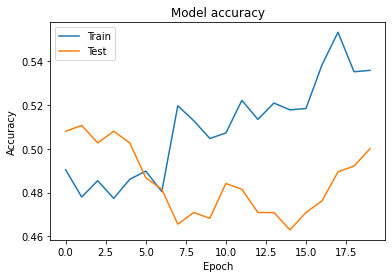

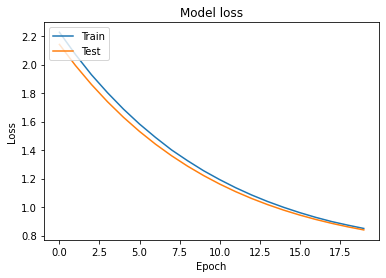

In [29]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [30]:
score = model.evaluate(X_test, Y_test)
print(score)

12/12 [==============================] - 0s 3ms/step - loss: 0.8398 - accuracy: 0.5000
[0.8397538661956787, 0.5]


# Use Word2Vec And Classifier

## Word2Vec

Use Word2Vec to find most similar words

In [31]:
class MyTokenizer():
    def __init__(self):
        self.tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
        self.lemmatizer = nltk.stem.WordNetLemmatizer()
        self.stop_words_en = set(nltk.corpus.stopwords.words('english'))
        self.stop_words_germ = set(nltk.corpus.stopwords.words('german'))
        self.stop_words = set()
        self.stop_words.add("b")
        
    def tokenize(self, headlines):
        # Tokenize
        tokens = [self.tokenizer.tokenize(article) for article in headlines]

        # Lemmatizer
        clean_tokens = []
        for words in tokens:
            clean_tokens.append([self.lemmatizer.lemmatize(word) for word in words])

        # Stop words
        final_tokens = []
        for words in clean_tokens:
            final_tokens.append([word.lower() for word in words if word.lower() not in self.stop_words_en and word.lower() not in self.stop_words_germ and word.lower() not in self.stop_words])
            
        return final_tokens

In [32]:
from gensim.models import Word2Vec

tokenizer = MyTokenizer()

headlines_train = train["headlines"]
headlines_test= test["headlines"]

tokens_train = tokenizer.tokenize(headlines_train)
tokens_test = tokenizer.tokenize(headlines_test)

model = Word2Vec(tokens_train, min_count=1,size= 50,workers=3, window =3, sg = 1)

word_vectors = model.wv
print("Number of word vectors: {}".format(len(word_vectors.vocab)))

print(model.wv.most_similar('husband'))

Number of word vectors: 29909
[('abusing', 0.976590633392334), ('murdering', 0.9715256690979004), ('adultery', 0.9708057045936584), ('attempted', 0.9699376821517944), ('teenage', 0.9674612283706665), ('repeatedly', 0.9667584300041199), ('abused', 0.9662029147148132), ('raping', 0.966062605381012), ('hanged', 0.9656693935394287), ('assaulted', 0.9653512239456177)]


## Word embedding

In [33]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from keras.layers import Flatten, Dense, LSTM, GRU, SpatialDropout1D, Bidirectional, concatenate
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
#from keras.optimizers import SGD

my_tokenizer = MyTokenizer()

headlines_train = train["headlines"]
headlines_test= test["headlines"]

tokens_train = my_tokenizer.tokenize(headlines_train)
tokens_test = my_tokenizer.tokenize(headlines_test)

tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(train["headlines"])
        
vocab_size = 20000 #len(tokenizer.word_index) + 1
print('Number of words: ' + str(vocab_size))

X_train_tokens = tokenizer.texts_to_sequences(tokens_train)
X_test_tokens = tokenizer.texts_to_sequences(tokens_test)

max_length = 0
for words in X_train_tokens:
    if len(words)>max_length:
        max_length = len(words)
max_length = 200
print('max_length: ' + str(max_length))

X_train_pad = pad_sequences(X_train_tokens, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_tokens, maxlen=max_length, padding='post')

y_train = train['Label']
y_test = test['Label']
Y_train = np_utils.to_categorical(y_train, 2)
Y_test = np_utils.to_categorical(y_test, 2)

Number of words: 20000
max_length: 200


## Deep Learning (Improve)

In [34]:
import tensorflow as tf
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 988598058113296871
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16486214308226850764
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

#### **LSTM 1** 

In [35]:
lstm_mod1 = Sequential()
# input layer
lstm_mod1.add(Embedding(vocab_size, 16, input_length=max_length))
# hidden layer (terdiri dari 6 layer yaitu 4 layer lstm, 1 layer fully connected, 1 layer dropout)
lstm_mod1.add(LSTM(256, return_sequences=True))
lstm_mod1.add(LSTM(256, return_sequences=True))
lstm_mod1.add(LSTM(256, return_sequences=True))
lstm_mod1.add(LSTM(256, return_sequences=False)) 
lstm_mod1.add(Dense(128, activation='relu', kernel_initializer='uniform'))
lstm_mod1.add(Dropout(0.2))
# 1 output layer
lstm_mod1.add(Dense(2, activation='sigmoid'))
# parameter
opt1 = tf.keras.optimizers.Adam(learning_rate=0.00005)
lstm_mod1.compile(optimizer=opt1, loss='binary_crossentropy', metrics=['accuracy'])

print(lstm_mod1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 16)           320000    
                                                                 
 lstm (LSTM)                 (None, 200, 256)          279552    
                                                                 
 lstm_1 (LSTM)               (None, 200, 256)          525312    
                                                                 
 lstm_2 (LSTM)               (None, 200, 256)          525312    
                                                                 
 lstm_3 (LSTM)               (None, 256)               525312    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)              

In [36]:
lstm_hist1 = lstm_mod1.fit(X_train_pad, Y_train, batch_size=16, epochs=20, verbose=1, validation_data=(X_test_pad, Y_test))

Epoch 1/20
101/101 [==============================] - 34s 247ms/step - loss: 0.6924 - accuracy: 0.5431 - val_loss: 0.6934 - val_accuracy: 0.5079
Epoch 2/20
101/101 [==============================] - 23s 229ms/step - loss: 0.6900 - accuracy: 0.5419 - val_loss: 0.6934 - val_accuracy: 0.5079
Epoch 3/20
101/101 [==============================] - 23s 229ms/step - loss: 0.6897 - accuracy: 0.5419 - val_loss: 0.6938 - val_accuracy: 0.5079
Epoch 4/20
101/101 [==============================] - 23s 229ms/step - loss: 0.6684 - accuracy: 0.5891 - val_loss: 0.7071 - val_accuracy: 0.5185
Epoch 5/20
101/101 [==============================] - 23s 229ms/step - loss: 0.5560 - accuracy: 0.7238 - val_loss: 0.8142 - val_accuracy: 0.5185
Epoch 6/20
101/101 [==============================] - 23s 229ms/step - loss: 0.3940 - accuracy: 0.8256 - val_loss: 0.9955 - val_accuracy: 0.5317
Epoch 7/20
101/101 [==============================] - 23s 229ms/step - loss: 0.2530 - accuracy: 0.9063 - val_loss: 1.2269 - val_ac

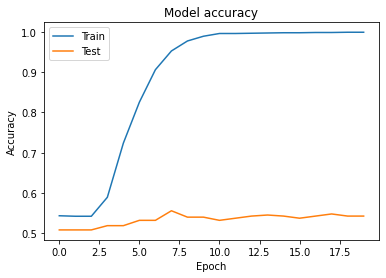

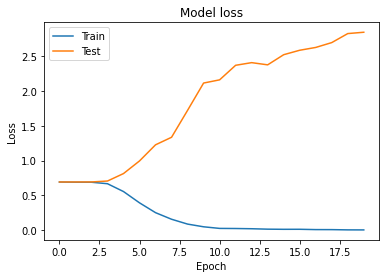

In [37]:
# Plot training & validation accuracy values
plt.plot(lstm_hist1.history['accuracy'])
plt.plot(lstm_hist1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(lstm_hist1.history['loss'])
plt.plot(lstm_hist1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [38]:
loss1, accuracy1 = lstm_mod1.evaluate(X_test_pad,Y_test)
print('Testing Accuracy is {} '.format(accuracy1*100))

12/12 [==============================] - 1s 122ms/step - loss: 2.8427 - accuracy: 0.5423
Testing Accuracy is 54.23280596733093 


In [39]:
y_pred1 = lstm_mod1.predict(X_test_pad)
y_predict1 = y_pred1>0.5

print("akurasi = ", accuracy_score(Y_test, y_predict1))
print("f1 score = ", f1_score(Y_test, y_predict1, average='macro'))
print("AUC = ", roc_auc_score(Y_test, y_predict1, average='macro'))

akurasi =  0.5423280423280423
f1 score =  0.5423202338786755
AUC =  0.5431787634408602


#### **LSTM 2** 

In [40]:
lstm_mod2 = Sequential()
lstm_mod2.add(Embedding(vocab_size, 16, input_length=max_length))
lstm_mod2.add(LSTM(256, return_sequences=True))
lstm_mod2.add(LSTM(256, return_sequences=True))
lstm_mod2.add(LSTM(256, return_sequences=True))
lstm_mod2.add(LSTM(256, return_sequences=False)) 
lstm_mod2.add(Dense(128, activation='relu', kernel_initializer='uniform'))
lstm_mod2.add(Dropout(0.2))
lstm_mod2.add(Dense(2, activation='sigmoid'))

opt2 = tf.keras.optimizers.Adam(learning_rate=0.00003)
lstm_mod2.compile(optimizer=opt2, loss='binary_crossentropy', metrics=['accuracy'])

print(lstm_mod2.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 16)           320000    
                                                                 
 lstm_4 (LSTM)               (None, 200, 256)          279552    
                                                                 
 lstm_5 (LSTM)               (None, 200, 256)          525312    
                                                                 
 lstm_6 (LSTM)               (None, 200, 256)          525312    
                                                                 
 lstm_7 (LSTM)               (None, 256)               525312    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)              

In [41]:
lstm_hist2 = lstm_mod2.fit(X_train_pad, Y_train, batch_size=16, epochs=20, verbose=1, validation_data=(X_test_pad, Y_test))

Epoch 1/20
101/101 [==============================] - 32s 246ms/step - loss: 0.6930 - accuracy: 0.5307 - val_loss: 0.6930 - val_accuracy: 0.5079
Epoch 2/20
101/101 [==============================] - 23s 229ms/step - loss: 0.6914 - accuracy: 0.5419 - val_loss: 0.6946 - val_accuracy: 0.5079
Epoch 3/20
101/101 [==============================] - 23s 229ms/step - loss: 0.6905 - accuracy: 0.5419 - val_loss: 0.6946 - val_accuracy: 0.5079
Epoch 4/20
101/101 [==============================] - 23s 229ms/step - loss: 0.6900 - accuracy: 0.5419 - val_loss: 0.6947 - val_accuracy: 0.5079
Epoch 5/20
101/101 [==============================] - 23s 229ms/step - loss: 0.6881 - accuracy: 0.5419 - val_loss: 0.6999 - val_accuracy: 0.5079
Epoch 6/20
101/101 [==============================] - 23s 229ms/step - loss: 0.6713 - accuracy: 0.5723 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/20
101/101 [==============================] - 23s 229ms/step - loss: 0.5581 - accuracy: 0.7287 - val_loss: 0.8175 - val_ac

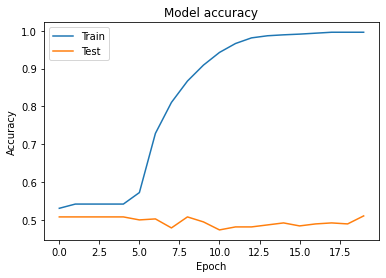

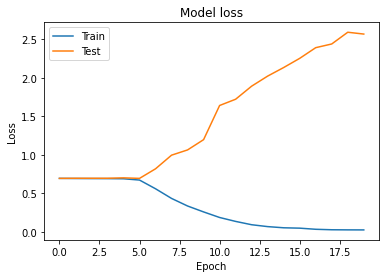

In [42]:
# Plot training & validation accuracy values
plt.plot(lstm_hist2.history['accuracy'])
plt.plot(lstm_hist2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(lstm_hist2.history['loss'])
plt.plot(lstm_hist2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [43]:
loss2, accuracy2 = lstm_mod2.evaluate(X_test_pad,Y_test)
print('Testing Accuracy is {} '.format(accuracy2*100))

12/12 [==============================] - 1s 122ms/step - loss: 2.5681 - accuracy: 0.5106
Testing Accuracy is 51.05820298194885 


In [44]:
y_pred2 = lstm_mod2.predict(X_test_pad)
y_predict2 = y_pred2>0.5

print("akurasi = ", accuracy_score(Y_test, y_predict2))
print("f1 score = ", f1_score(Y_test, y_predict2, average='macro'))
print("AUC = ", roc_auc_score(Y_test, y_predict2, average='macro'))

akurasi =  0.5105820105820106
f1 score =  0.5104851858098611
AUC =  0.512642809139785


#### **LSTM 3** 

In [45]:
lstm_mod3 = Sequential()
lstm_mod3.add(Embedding(vocab_size, 16, input_length=max_length))
lstm_mod3.add(LSTM(256, return_sequences=True))
lstm_mod3.add(LSTM(256, return_sequences=True))
lstm_mod3.add(LSTM(256, return_sequences=True))
lstm_mod3.add(LSTM(256, return_sequences=False)) 
lstm_mod3.add(Dense(128, activation='relu', kernel_initializer='uniform'))
lstm_mod3.add(Dropout(0.2))
lstm_mod3.add(Dense(2, activation='sigmoid'))

opt3 = tf.keras.optimizers.Adam(learning_rate=0.00002)
lstm_mod3.compile(optimizer=opt3, loss='binary_crossentropy', metrics=['accuracy'])

print(lstm_mod3.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 16)           320000    
                                                                 
 lstm_8 (LSTM)               (None, 200, 256)          279552    
                                                                 
 lstm_9 (LSTM)               (None, 200, 256)          525312    
                                                                 
 lstm_10 (LSTM)              (None, 200, 256)          525312    
                                                                 
 lstm_11 (LSTM)              (None, 256)               525312    
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)              

In [46]:
lstm_hist3 = lstm_mod3.fit(X_train_pad, Y_train, batch_size=16, epochs=20, verbose=1, validation_data=(X_test_pad, Y_test))

Epoch 1/20
101/101 [==============================] - 32s 248ms/step - loss: 0.6930 - accuracy: 0.5413 - val_loss: 0.6931 - val_accuracy: 0.5079
Epoch 2/20
101/101 [==============================] - 23s 230ms/step - loss: 0.6921 - accuracy: 0.5419 - val_loss: 0.6933 - val_accuracy: 0.5079
Epoch 3/20
101/101 [==============================] - 23s 229ms/step - loss: 0.6904 - accuracy: 0.5419 - val_loss: 0.6949 - val_accuracy: 0.5079
Epoch 4/20
101/101 [==============================] - 23s 229ms/step - loss: 0.6896 - accuracy: 0.5419 - val_loss: 0.6945 - val_accuracy: 0.5079
Epoch 5/20
101/101 [==============================] - 23s 229ms/step - loss: 0.6892 - accuracy: 0.5419 - val_loss: 0.6947 - val_accuracy: 0.5079
Epoch 6/20
101/101 [==============================] - 23s 229ms/step - loss: 0.6874 - accuracy: 0.5419 - val_loss: 0.6969 - val_accuracy: 0.5079
Epoch 7/20
101/101 [==============================] - 23s 230ms/step - loss: 0.6639 - accuracy: 0.6034 - val_loss: 0.7456 - val_ac

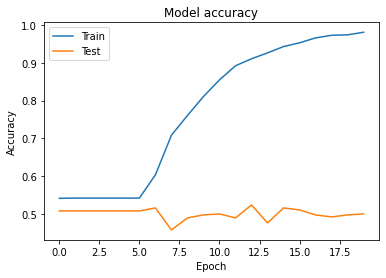

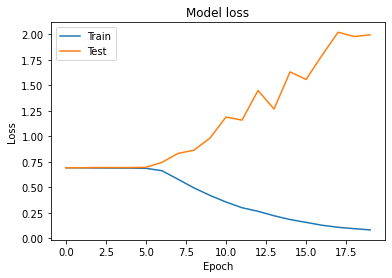

In [47]:
# Plot training & validation accuracy values
plt.plot(lstm_hist3.history['accuracy'])
plt.plot(lstm_hist3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(lstm_hist3.history['loss'])
plt.plot(lstm_hist3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [48]:
loss3, accuracy3 = lstm_mod3.evaluate(X_test_pad,Y_test)
print('Testing Accuracy is {} '.format(accuracy3*100))

12/12 [==============================] - 1s 117ms/step - loss: 1.9953 - accuracy: 0.5000
Testing Accuracy is 50.0 


In [49]:
y_pred3 = lstm_mod3.predict(X_test_pad)
y_predict3 = y_pred3>0.5

print("akurasi = ", accuracy_score(Y_test, y_predict3))
print("f1 score = ", f1_score(Y_test, y_predict3, average='macro'))
print("AUC = ", roc_auc_score(Y_test, y_predict3, average='macro'))

akurasi =  0.4973544973544973
f1 score =  0.4974852195354311
AUC =  0.49785786290322587
